
Processing test_image_8_plant_1.png...


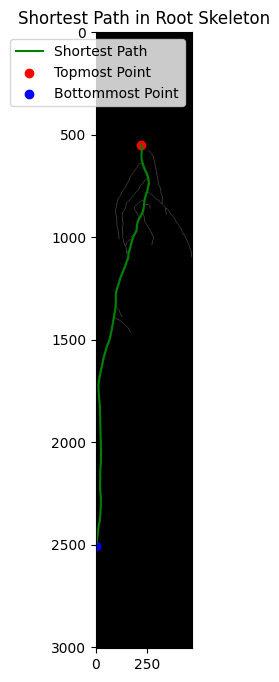

Shortest Path Length: 2099.25 pixels

Processing test_image_18_plant_4.png...


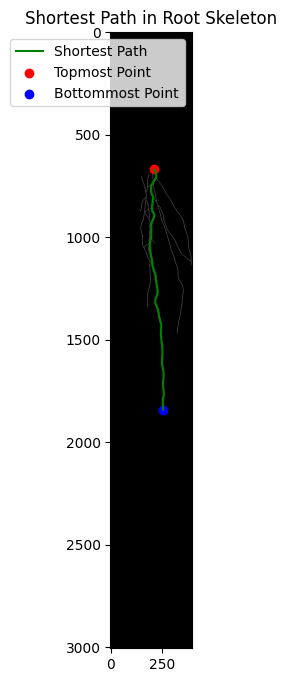

Shortest Path Length: 1259.33 pixels

Processing test_image_8_plant_2.png...


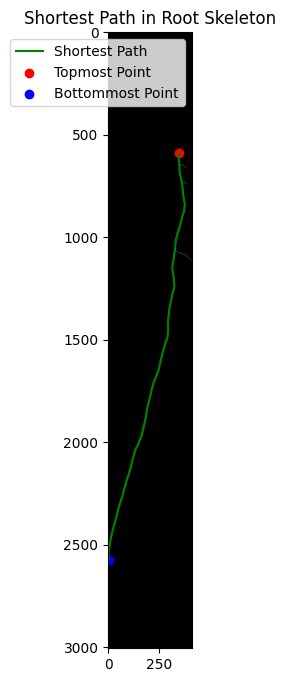

Shortest Path Length: 2164.28 pixels

Processing test_image_8_plant_4.png...


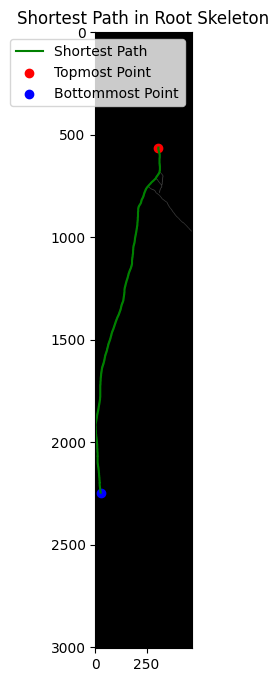

Shortest Path Length: 1832.39 pixels

Processing test_image_18_plant_5.png...


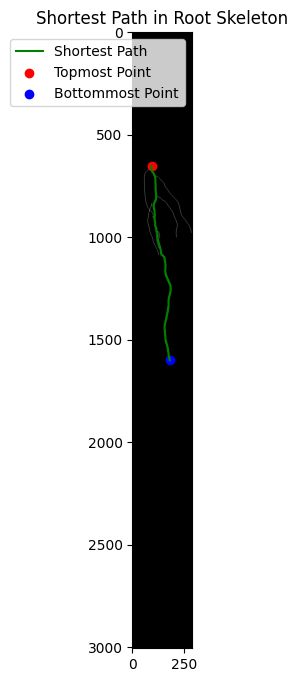

Shortest Path Length: 1025.80 pixels

Processing test_image_18_plant_1.png...


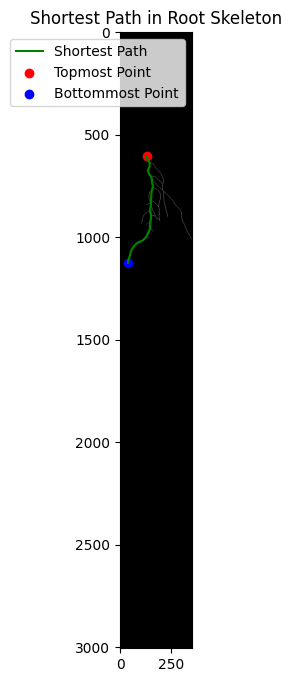

Shortest Path Length: 606.35 pixels

Processing test_image_13_plant_1.png...


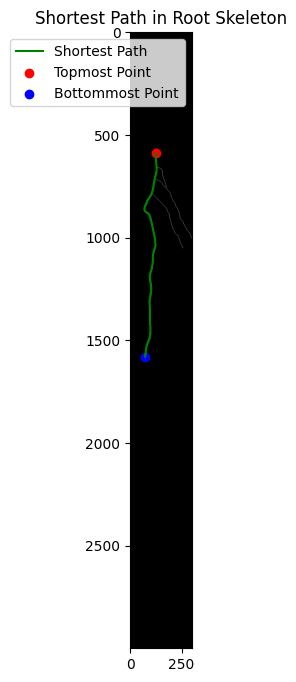

Shortest Path Length: 1076.43 pixels

Processing test_image_12_plant_1.png...


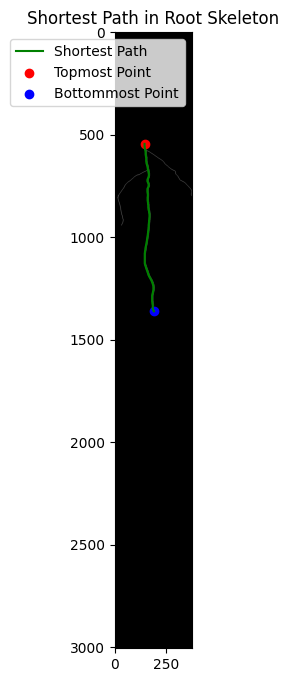

Shortest Path Length: 873.33 pixels

Processing test_image_12_plant_2.png...


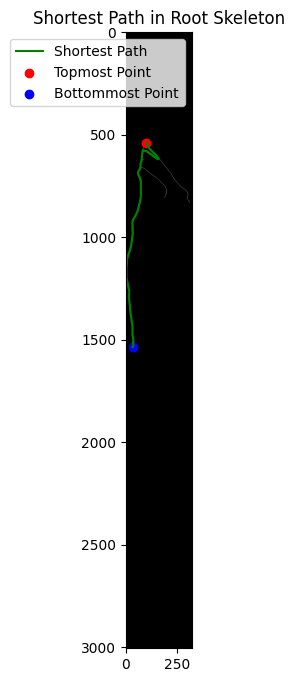

Shortest Path Length: 1228.01 pixels

Processing test_image_11_plant_5.png...


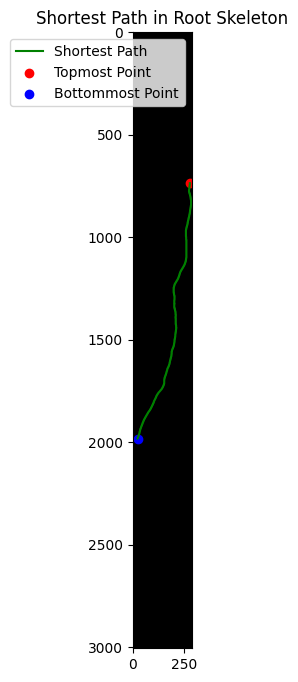

Shortest Path Length: 1374.82 pixels


In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from skimage.morphology import skeletonize
from skan import Skeleton, summarize
from skimage.measure import label
from natsort import natsorted


def prioritize_images(image_paths, criteria="size"):
    """
    Prioritize images based on a specified criteria.
    Args:
        image_paths: List of image file paths.
        criteria: Criterion to sort the images. Options: 'size', 'modification_time'.
    Returns:
        List of prioritized image file paths.
    """
    if criteria == "size":
        # Sort by file size (largest first)
        prioritized = sorted(image_paths, key=lambda x: os.path.getsize(x), reverse=True)
    elif criteria == "modification_time":
        # Sort by modification time (newest first)
        prioritized = sorted(image_paths, key=lambda x: os.path.getmtime(x), reverse=True)
    else:
        raise ValueError(f"Unsupported prioritization criteria: {criteria}")
    
    return prioritized[:10]  # Return the top 10 based on the chosen criteria


def extract_skeleton_data(image_path):
    """
    Extract skeletonized image and graph data from the given image.
    Args:
        image_path: File path of the input image.
    Returns:
        skeleton_df: DataFrame with skeleton graph details.
        skeleton_img: Binary skeletonized image of the input.
    """
    grayscale_img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if grayscale_img is None:
        print(f"Error: Unable to read image at {image_path}")
        return None, None

    binary_img = grayscale_img > 0
    skeleton_img = skeletonize(binary_img)

    if not skeleton_img.any():
        print(f"No skeleton data found for image {os.path.basename(image_path)}")
        return None, skeleton_img

    try:
        skel_obj = Skeleton(skeleton_img)
        skeleton_df = summarize(skel_obj)
    except ValueError as err:
        print(f"Error processing skeleton graph for {os.path.basename(image_path)}: {err}")
        return None, skeleton_img

    return skeleton_df, skeleton_img


def calculate_shortest_path(skeleton_img):
    """
    Calculate the shortest path between the topmost and bottommost points.
    Args:
        skeleton_img: Binary skeletonized image.
    Returns:
        float: Length of the shortest path in pixels.
    """
    if skeleton_img is None or not np.any(skeleton_img):
        print("Invalid or empty skeleton data provided.")
        return None

    labeled_img = label(skeleton_img)
    largest_comp_label = np.argmax(np.bincount(labeled_img.ravel())[1:]) + 1
    skeleton_img = (labeled_img == largest_comp_label)

    coords = np.argwhere(skeleton_img)
    topmost = tuple(coords[np.argmin(coords[:, 0])])
    bottommost = tuple(coords[np.argmax(coords[:, 0])])

    graph = nx.Graph()
    for (x, y) in coords:
        for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1), (-1, -1), (-1, 1), (1, -1), (1, 1)]:
            neighbor = (x + dx, y + dy)
            if tuple(neighbor) in map(tuple, coords):
                dist = np.sqrt(dx**2 + dy**2)
                graph.add_edge((x, y), neighbor, weight=dist)

    if not (graph.has_node(topmost) and graph.has_node(bottommost)):
        print("Endpoints are not in the graph. Skipping path calculation.")
        return None

    try:
        path_length = nx.shortest_path_length(graph, source=topmost, target=bottommost, weight='weight')
    except nx.NetworkXNoPath:
        print("No path found between endpoints in the skeleton.")
        return None

    plt.figure(figsize=(8, 8))
    plt.imshow(skeleton_img, cmap='gray')
    shortest_path = nx.shortest_path(graph, source=topmost, target=bottommost, weight='weight')
    path_coords = np.array(shortest_path)
    plt.plot(path_coords[:, 1], path_coords[:, 0], color='green', label='Shortest Path')
    plt.scatter(topmost[1], topmost[0], color='red', label='Topmost Point')
    plt.scatter(bottommost[1], bottommost[0], color='blue', label='Bottommost Point')
    plt.legend()
    plt.title("Shortest Path in Root Skeleton")
    plt.show()

    return path_length


def process_images(image_paths, extract_func):
    """
    Process a batch of prioritized images to compute shortest paths.
    Args:
        image_paths: List of prioritized image file paths.
        extract_func: Function to extract skeleton data from images.
    """
    for img_path in image_paths:
        print(f"\nProcessing {os.path.basename(img_path)}...")

        skel_df, skel_img = extract_func(img_path)

        if skel_img is not None and skel_df is not None:
            path_length = calculate_shortest_path(skel_img)
            if path_length is not None:
                print(f"Shortest Path Length: {path_length:.2f} pixels")
            else:
                print(f"Failed to calculate path for {os.path.basename(img_path)}")
        else:
            print(f"Invalid skeleton data for {os.path.basename(img_path)}")


# Main execution
if __name__ == "__main__":
    folder = "./processed_roots"
    all_images = natsorted(
        [
            os.path.join(folder, file)
            for file in os.listdir(folder)
            if file.endswith(".png")
        ]
    )

    # Prioritize the last 10 images based on file size
    prioritized_images = prioritize_images(all_images, criteria="size")

    # Process the prioritized images
    process_images(prioritized_images, extract_skeleton_data)


Analyzing: test_image_1_plant_1.png


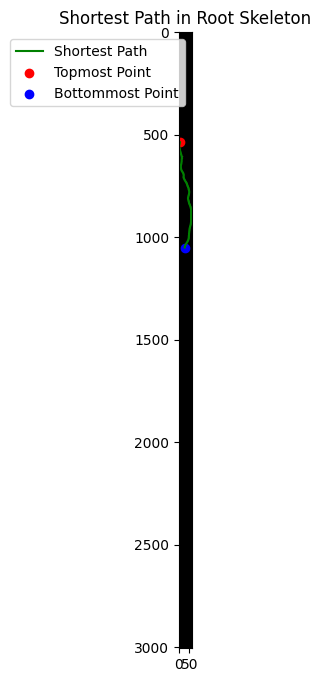

Analyzing: test_image_1_plant_3.png


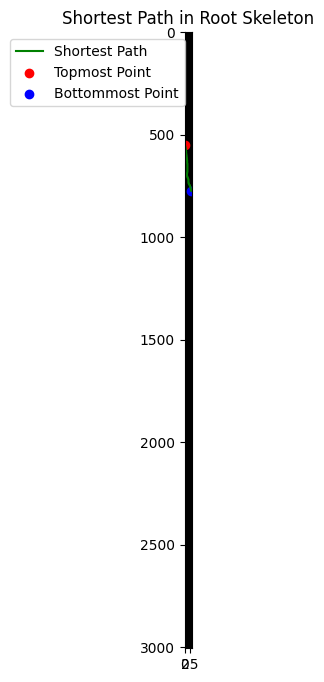

Analyzing: test_image_2_plant_1.png


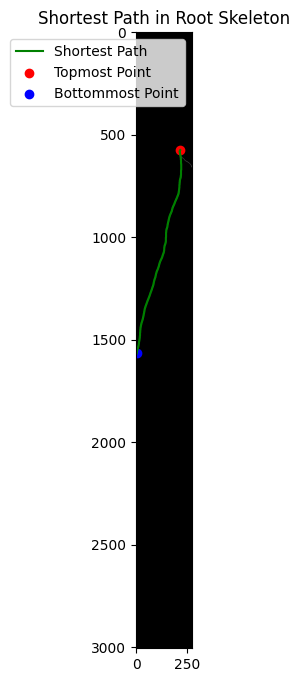

Analyzing: test_image_2_plant_2.png


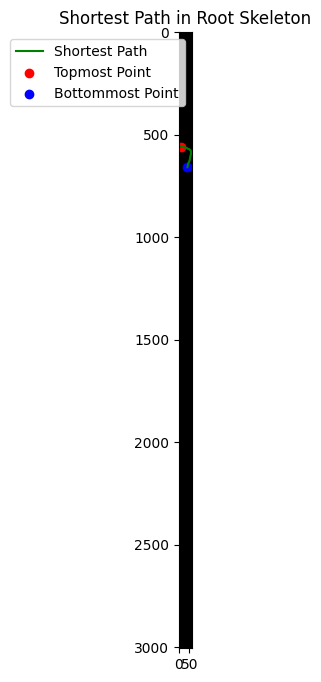

Analyzing: test_image_2_plant_3.png


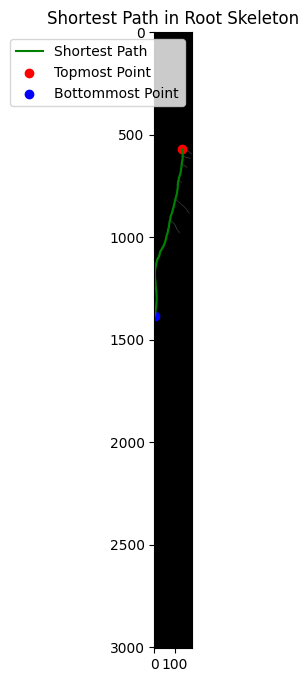

Analyzing: test_image_2_plant_4.png


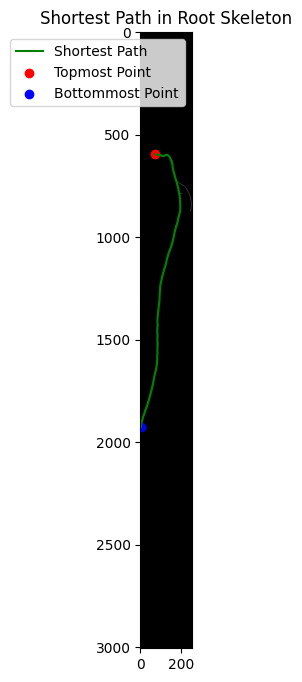

Analyzing: test_image_2_plant_5.png


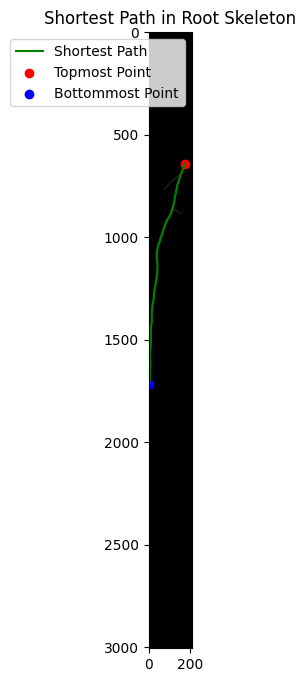

Analyzing: test_image_3_plant_1.png


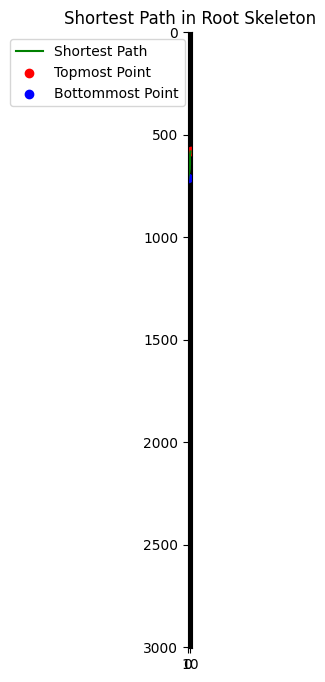

Analyzing: test_image_3_plant_2.png


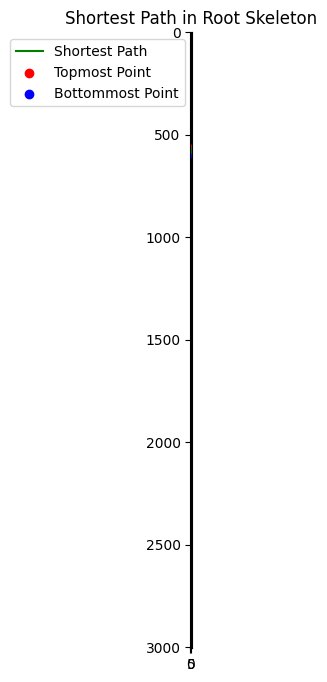

Analyzing: test_image_3_plant_3.png


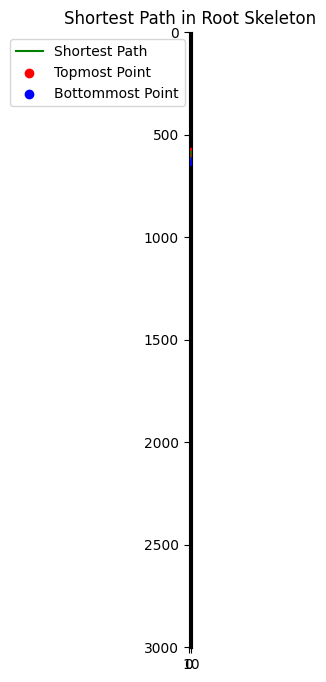

Analyzing: test_image_3_plant_4.png


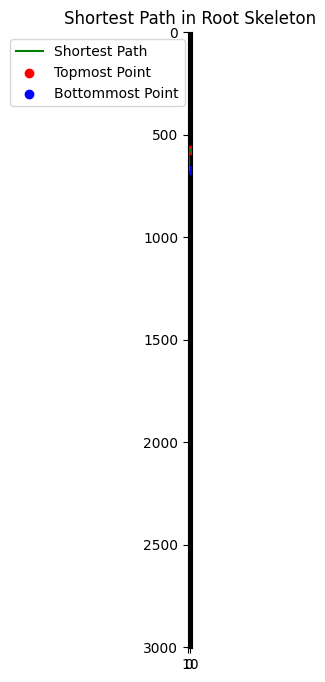

Analyzing: test_image_3_plant_5.png


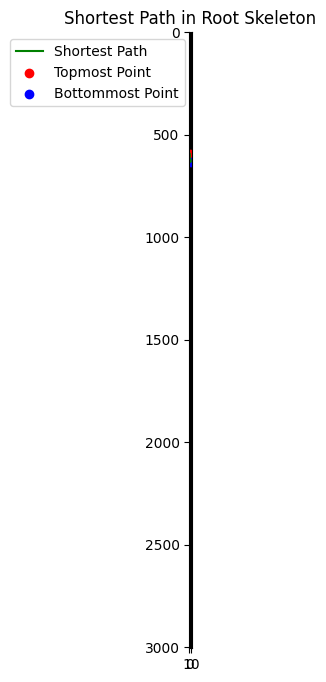

Analyzing: test_image_4_plant_1.png


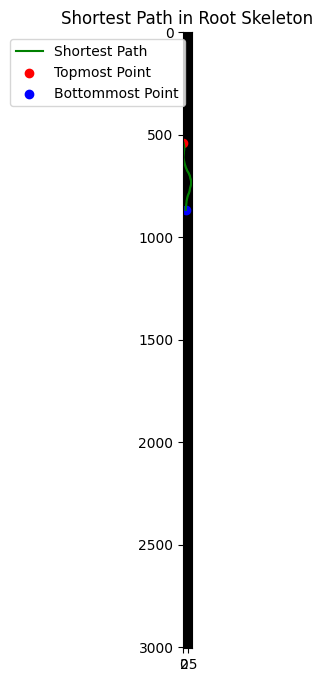

Analyzing: test_image_4_plant_2.png


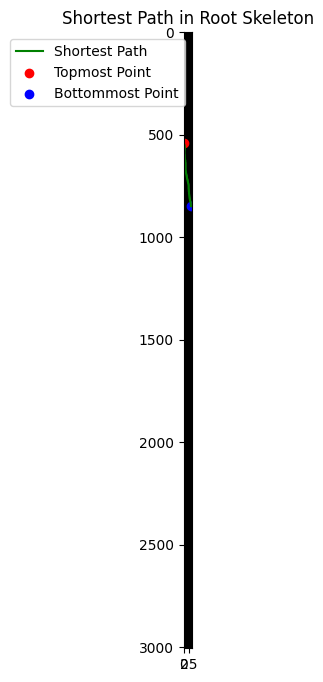

Analyzing: test_image_4_plant_3.png


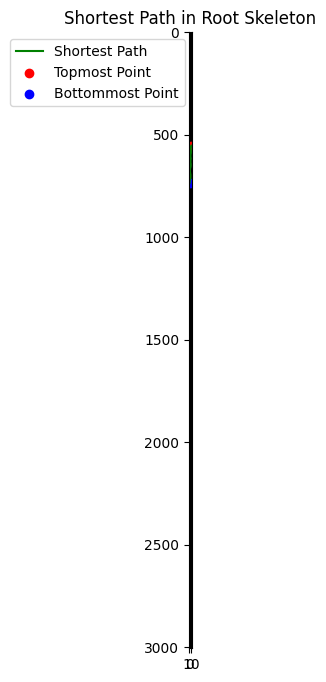

Analyzing: test_image_4_plant_4.png


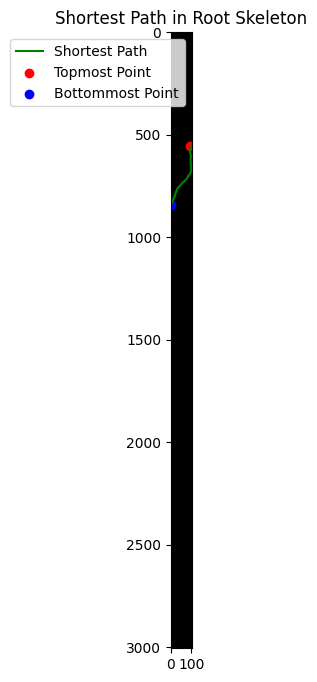

Analyzing: test_image_4_plant_5.png


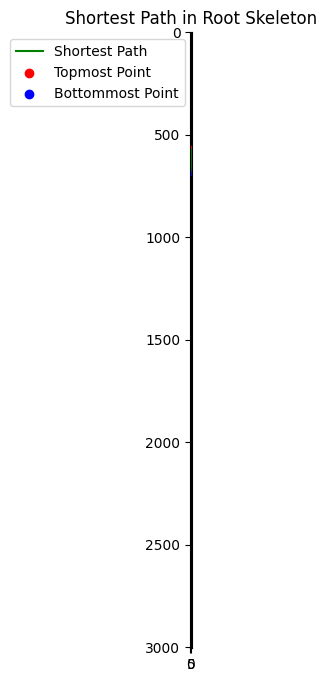

Analyzing: test_image_5_plant_1.png


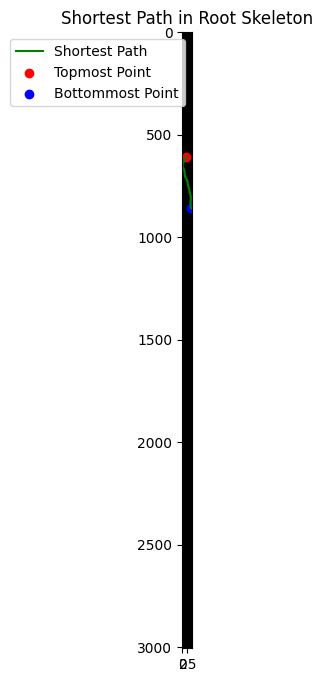

Analyzing: test_image_5_plant_2.png


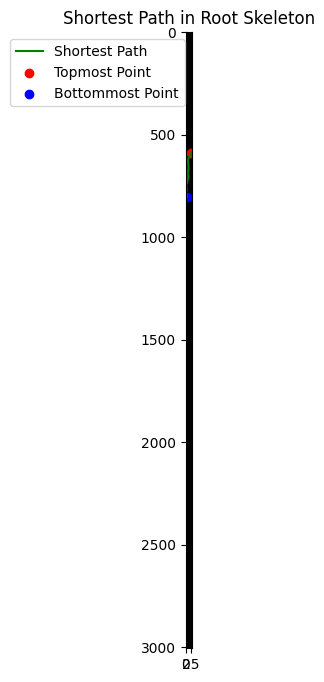

Analyzing: test_image_5_plant_3.png


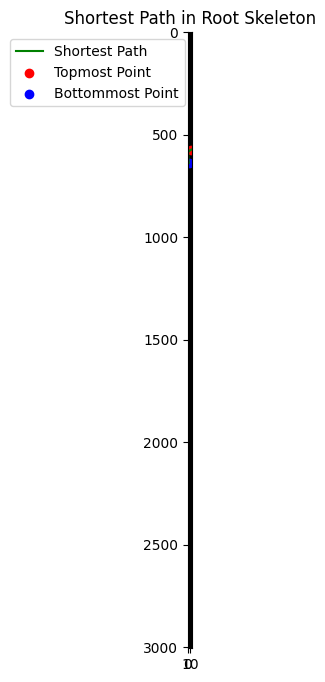

Analyzing: test_image_5_plant_4.png


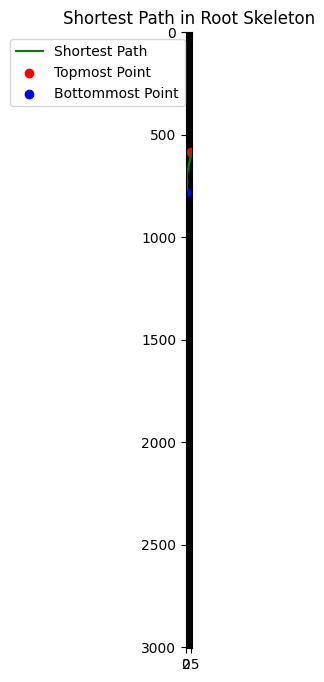

Analyzing: test_image_5_plant_5.png


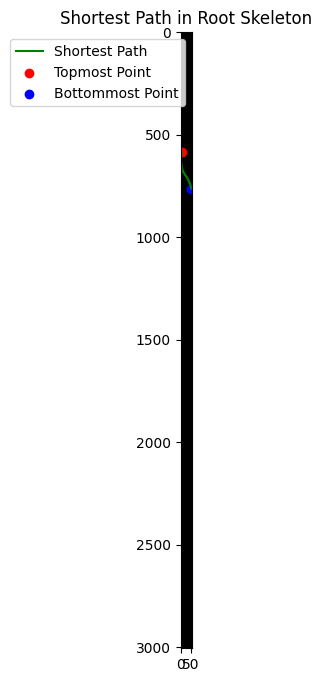

Analyzing: test_image_6_plant_1.png


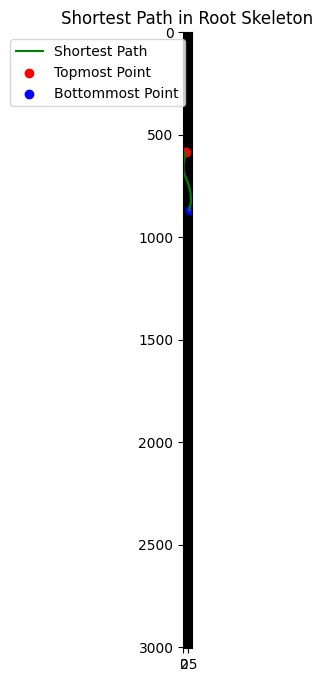

Analyzing: test_image_6_plant_2.png


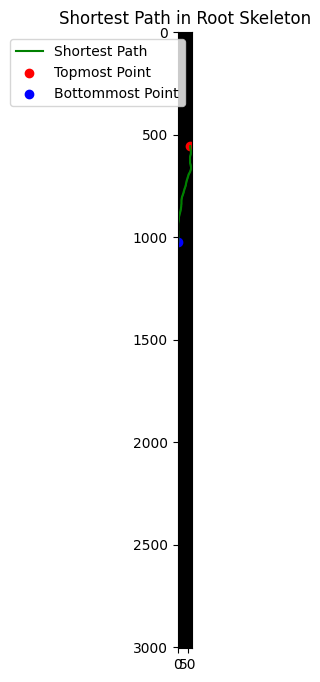

Analyzing: test_image_6_plant_3.png


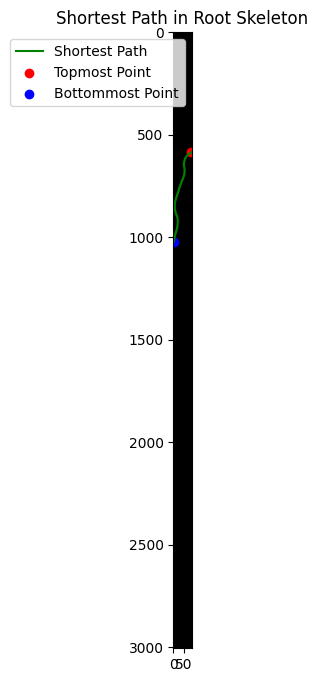

Analyzing: test_image_6_plant_4.png


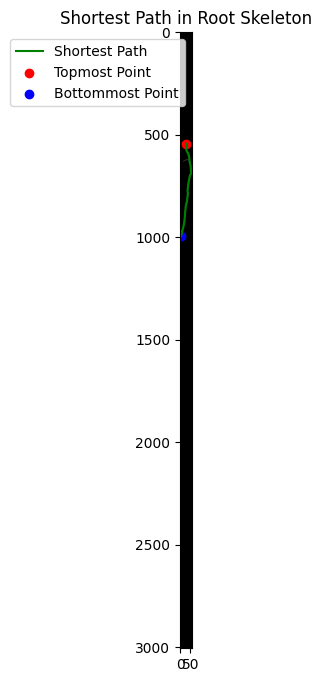

Analyzing: test_image_6_plant_5.png


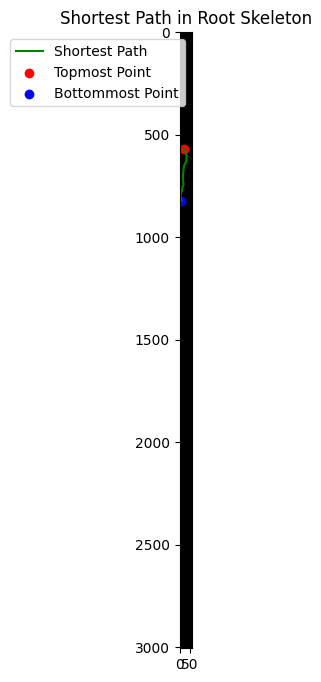

Analyzing: test_image_7_plant_1.png


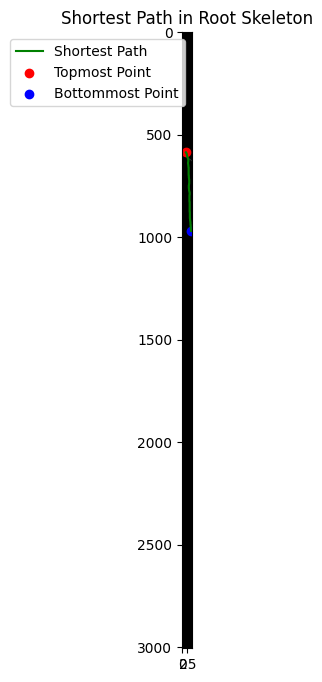

Analyzing: test_image_7_plant_2.png


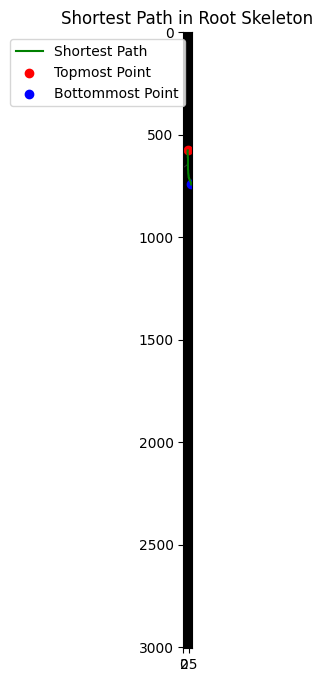

Analyzing: test_image_7_plant_3.png


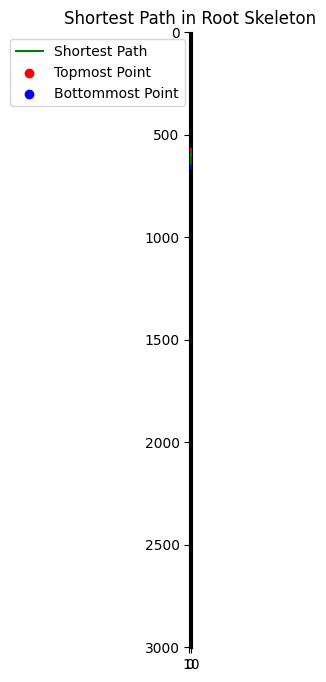

Analyzing: test_image_7_plant_4.png


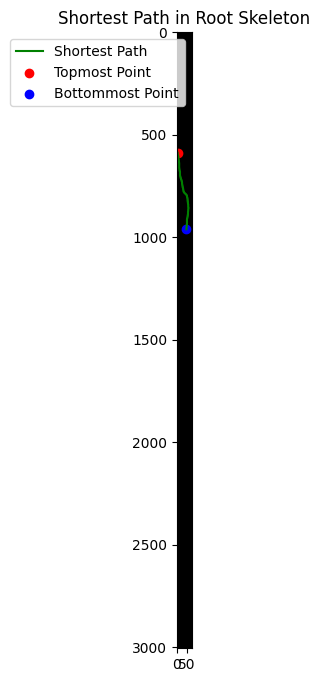

Analyzing: test_image_7_plant_5.png


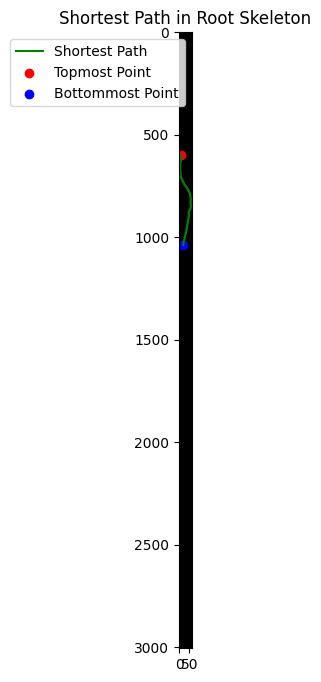

Analyzing: test_image_8_plant_1.png


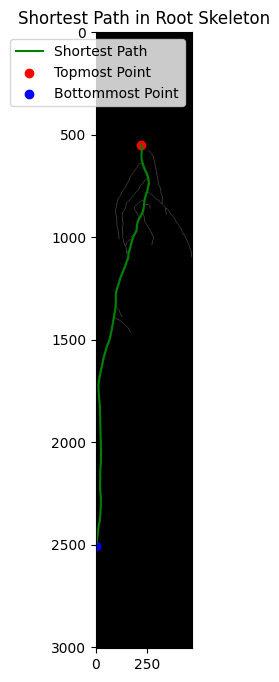

Analyzing: test_image_8_plant_2.png


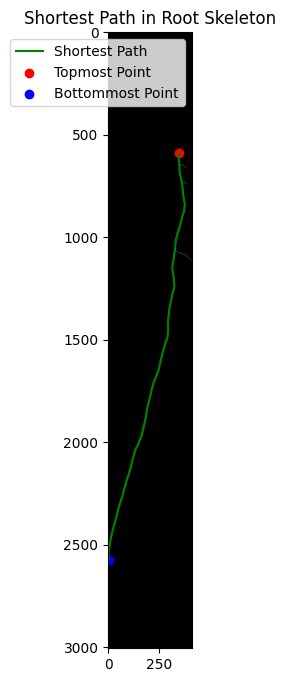

Analyzing: test_image_8_plant_3.png


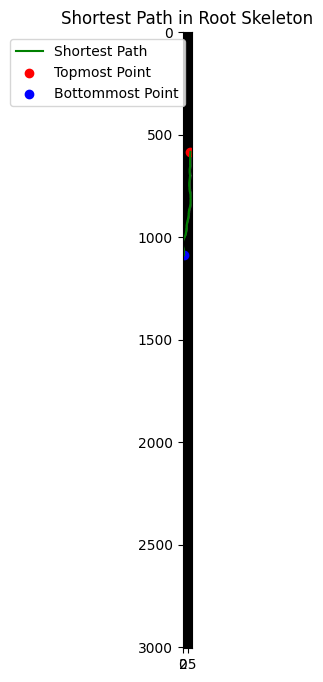

Analyzing: test_image_8_plant_4.png


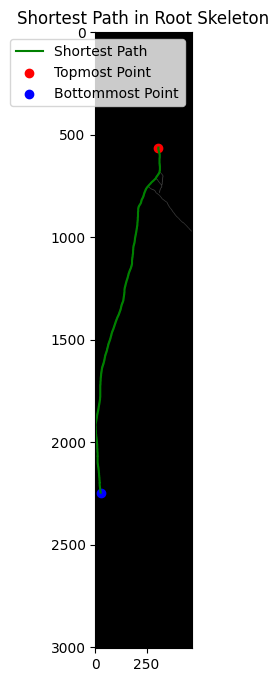

Analyzing: test_image_8_plant_5.png


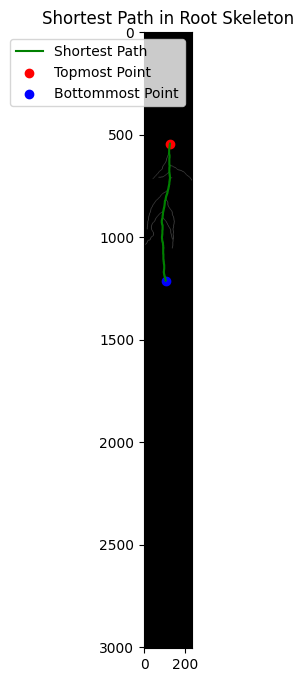

Analyzing: test_image_9_plant_1.png


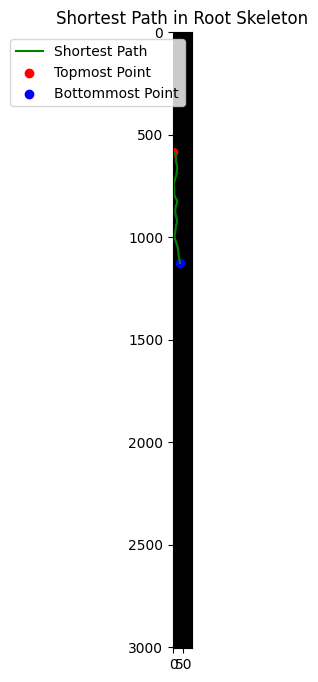

Analyzing: test_image_9_plant_2.png


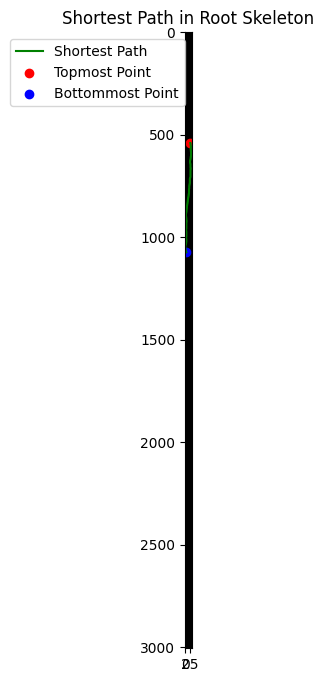

Analyzing: test_image_9_plant_3.png


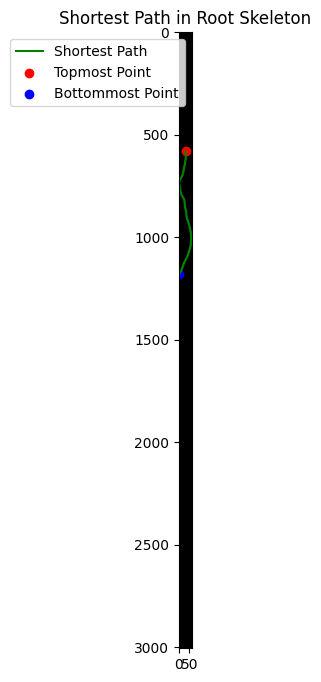

Analyzing: test_image_9_plant_4.png


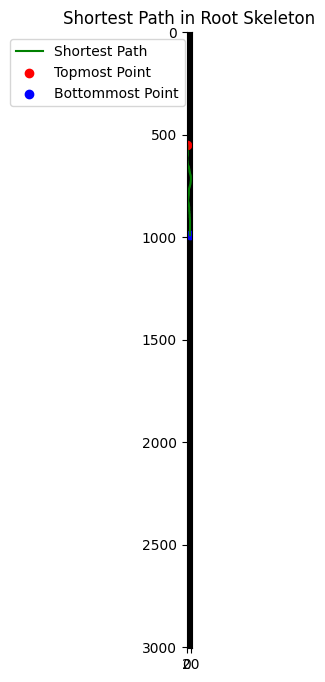

Analyzing: test_image_9_plant_5.png


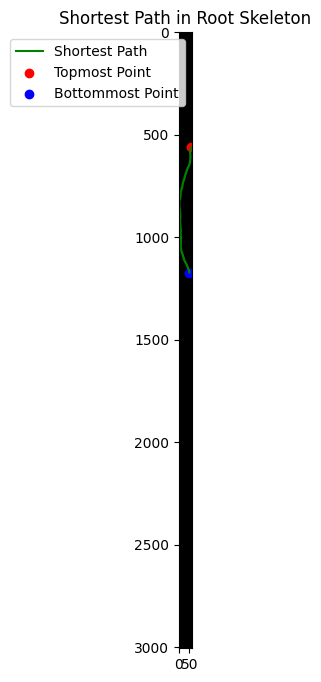

Analyzing: test_image_10_plant_1.png


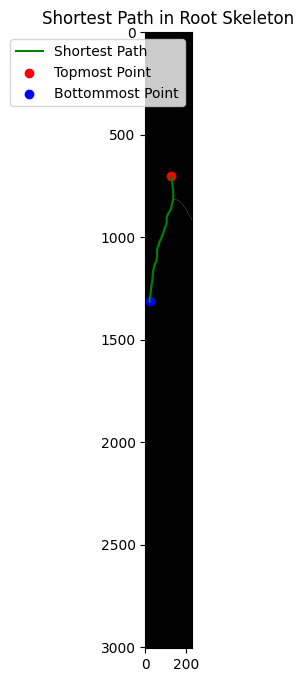

Analyzing: test_image_10_plant_2.png


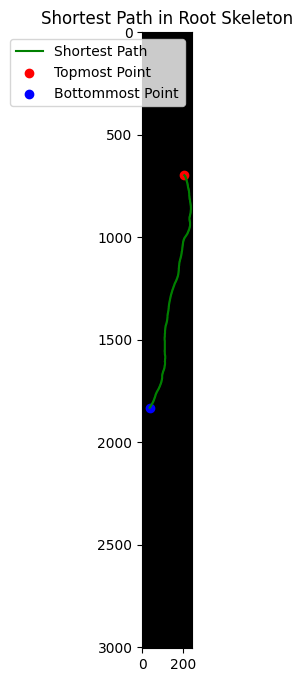

Analyzing: test_image_10_plant_3.png


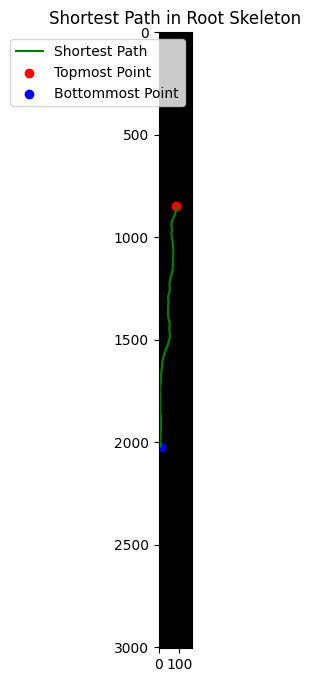

Analyzing: test_image_10_plant_4.png


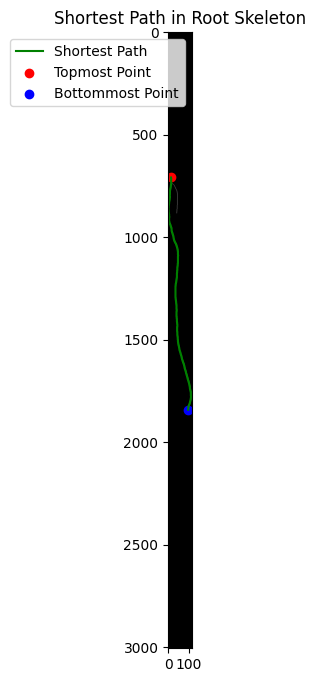

Analyzing: test_image_10_plant_5.png


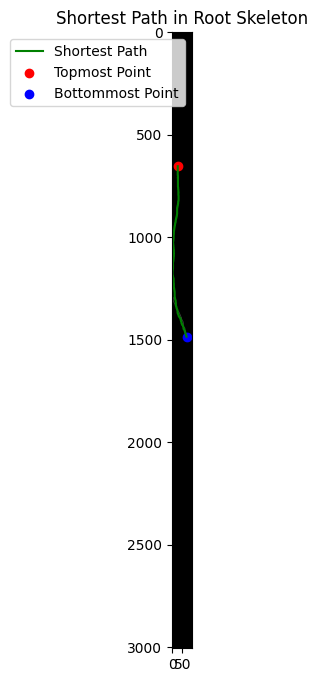

Analyzing: test_image_11_plant_1.png


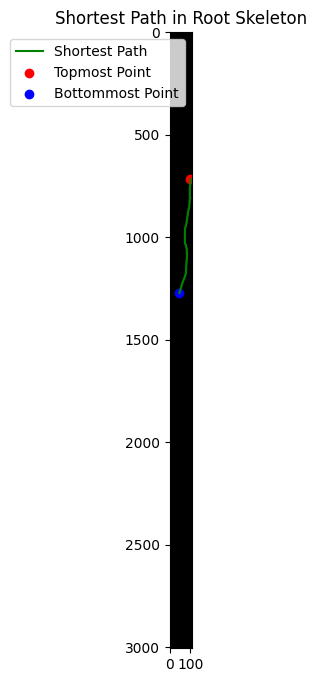

Analyzing: test_image_11_plant_2.png


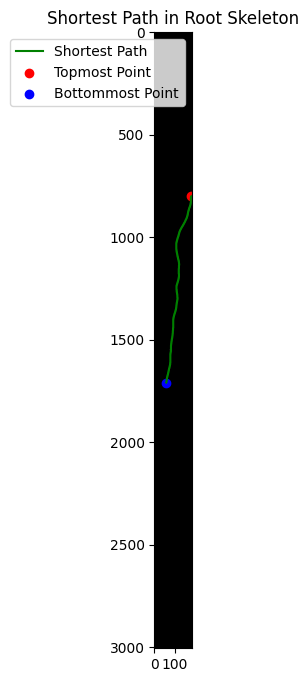

Analyzing: test_image_11_plant_3.png


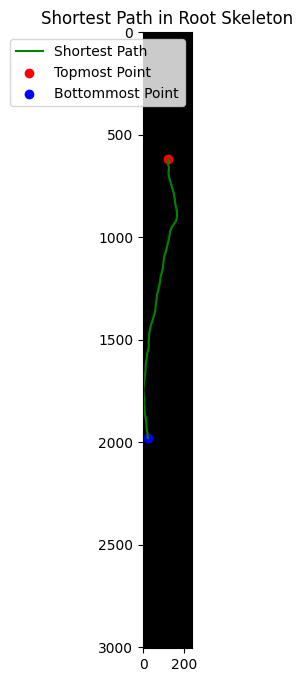

Analyzing: test_image_11_plant_4.png


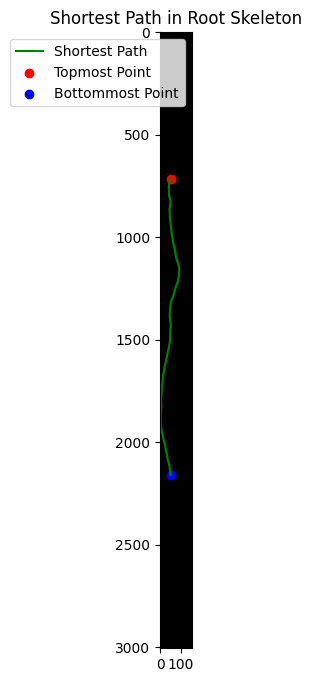

Analyzing: test_image_11_plant_5.png


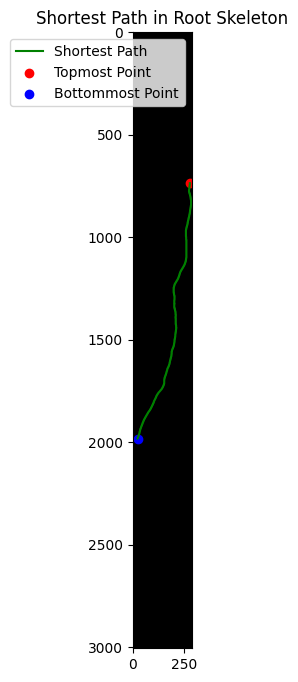

Analyzing: test_image_12_plant_1.png


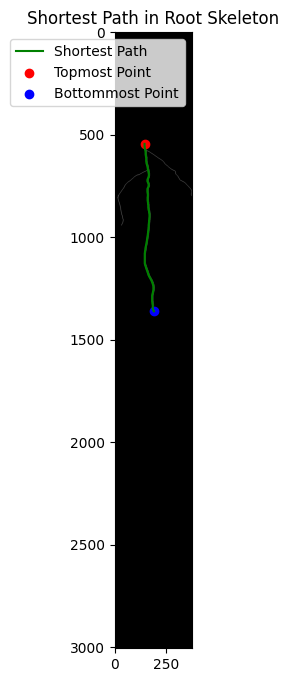

Analyzing: test_image_12_plant_2.png


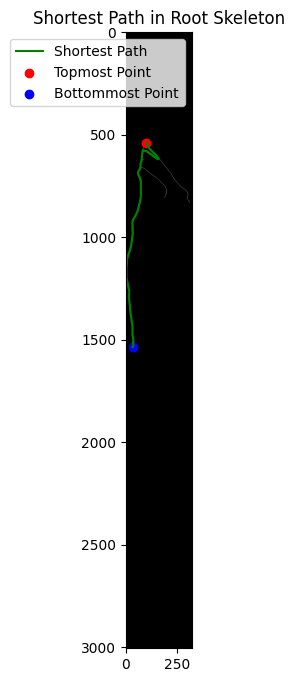

Analyzing: test_image_12_plant_3.png


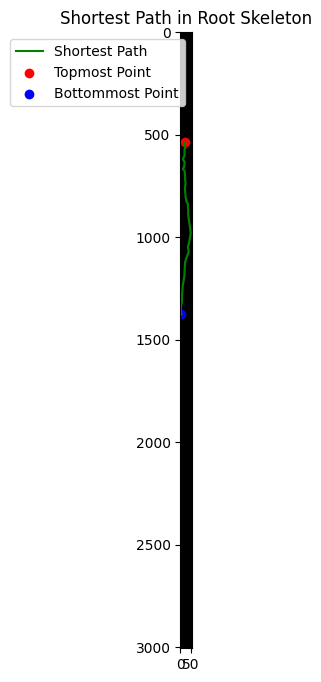

Analyzing: test_image_12_plant_4.png


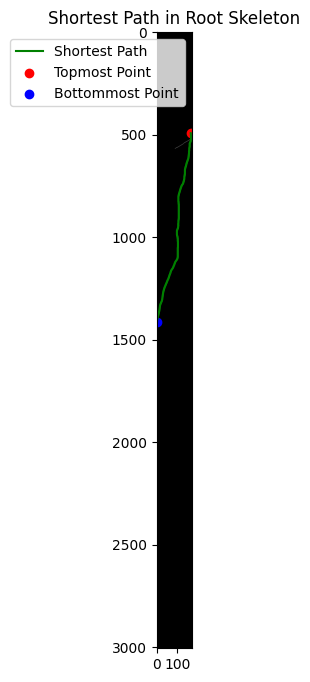

Analyzing: test_image_12_plant_5.png


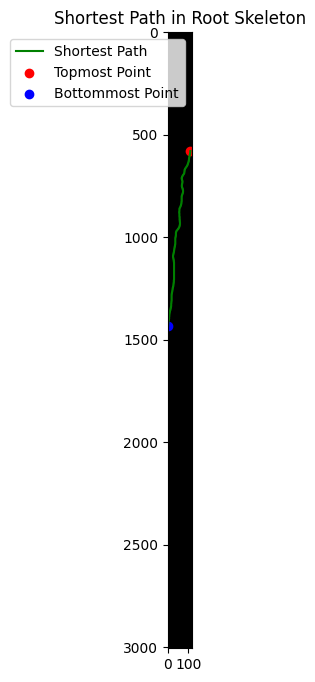

Analyzing: test_image_13_plant_1.png


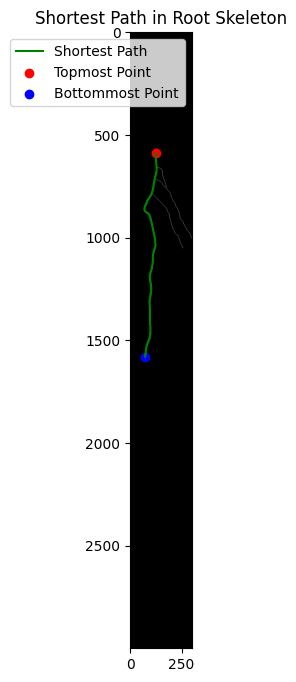

Analyzing: test_image_13_plant_2.png


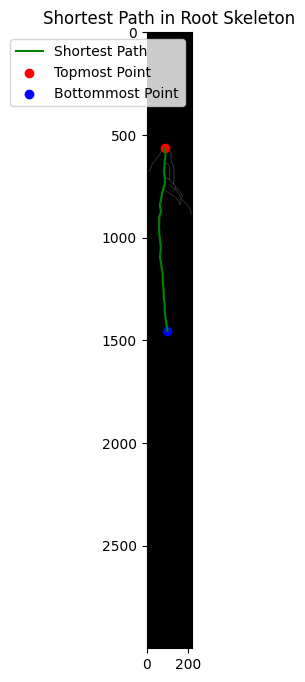

Analyzing: test_image_13_plant_3.png


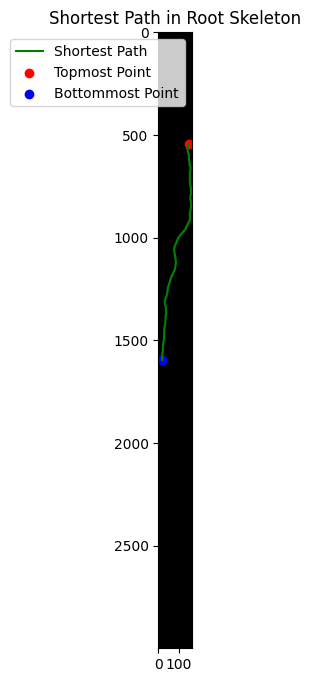

Analyzing: test_image_13_plant_4.png


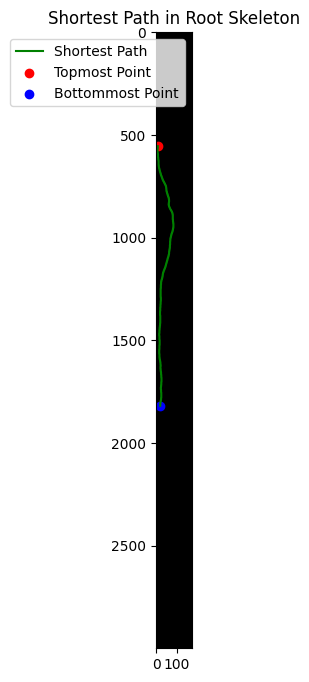

Analyzing: test_image_13_plant_5.png


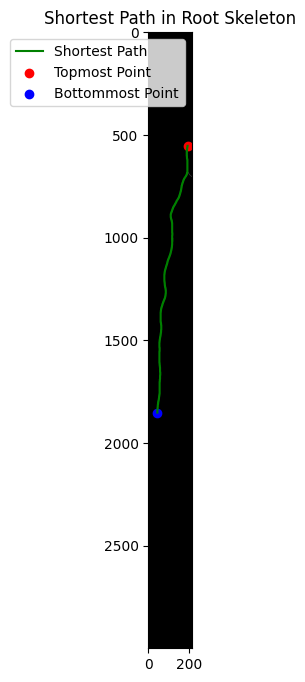

Analyzing: test_image_14_plant_1.png


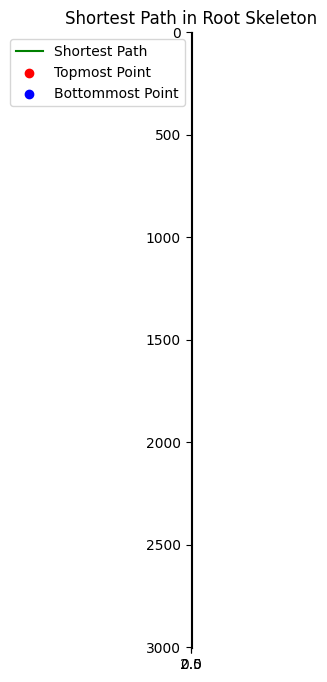

Analyzing: test_image_14_plant_2.png


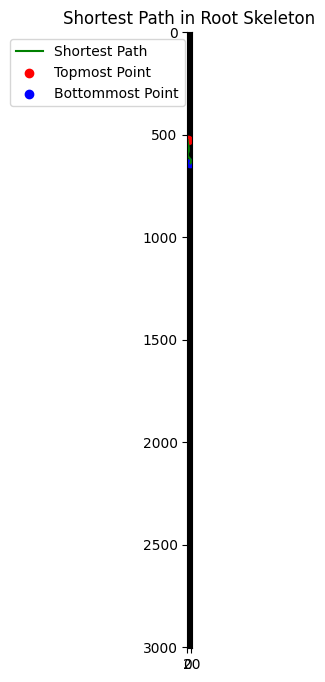

Analyzing: test_image_14_plant_3.png


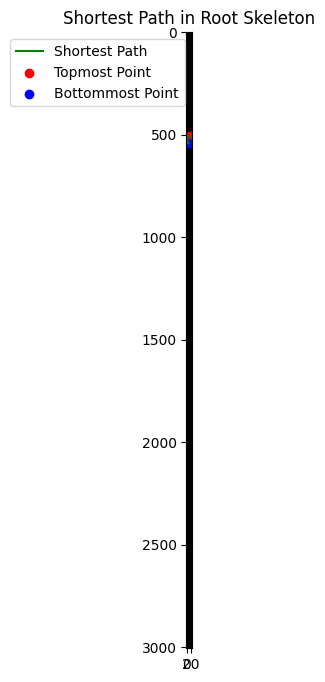

Analyzing: test_image_14_plant_4.png


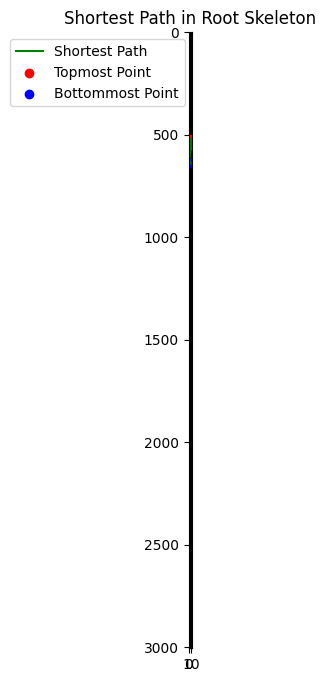

Analyzing: test_image_14_plant_5.png


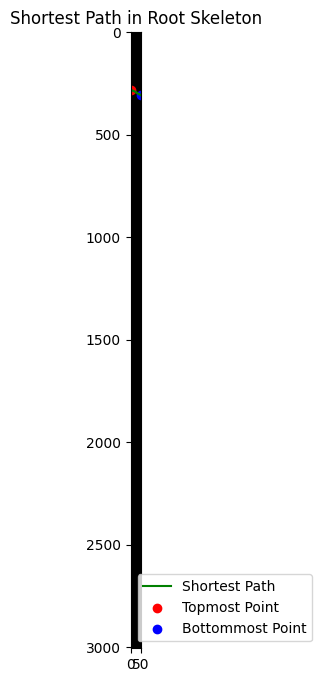

Analyzing: test_image_15_plant_1.png


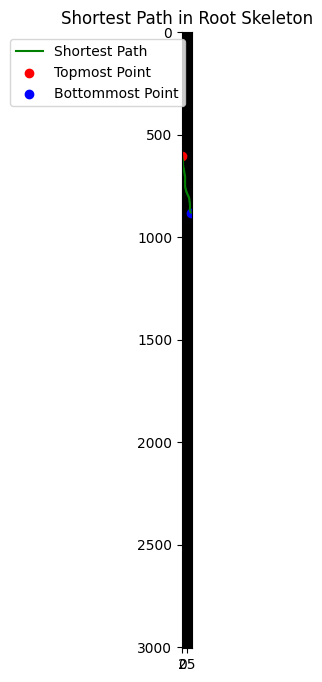

Analyzing: test_image_15_plant_2.png


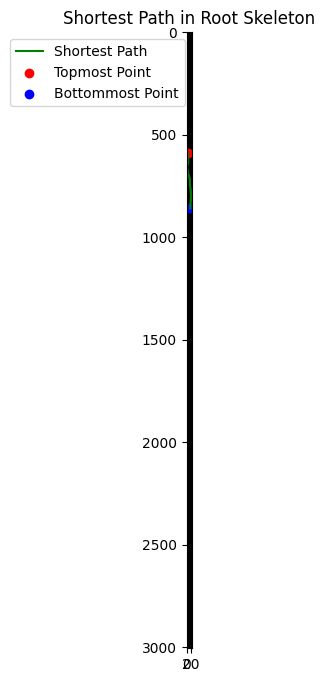

Analyzing: test_image_15_plant_3.png


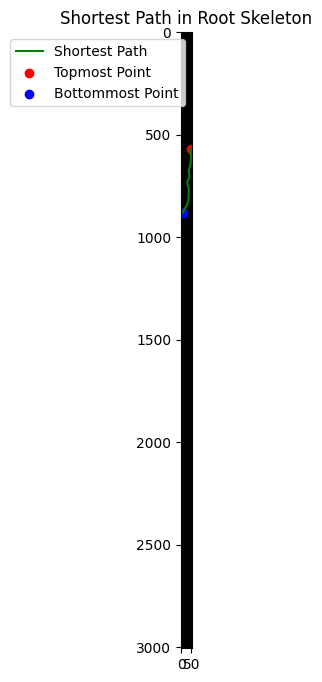

Analyzing: test_image_15_plant_4.png


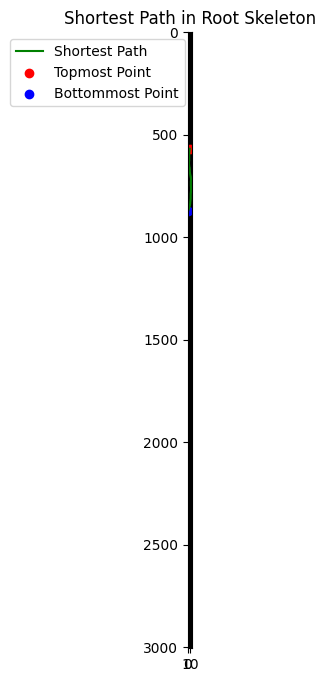

Analyzing: test_image_15_plant_5.png


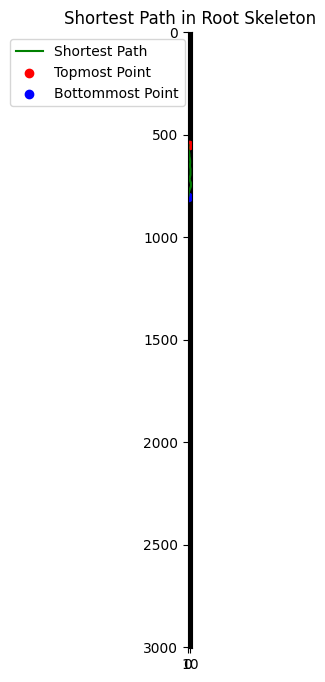

Analyzing: test_image_16_plant_1.png


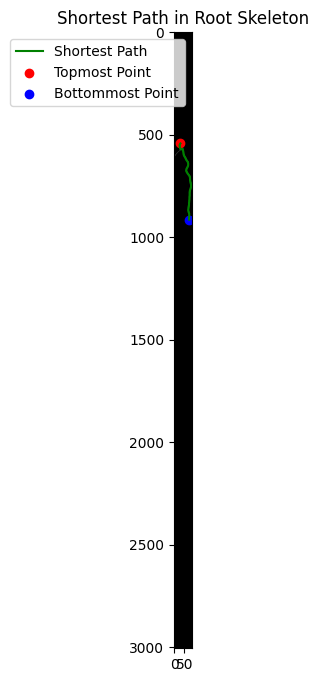

Analyzing: test_image_16_plant_2.png


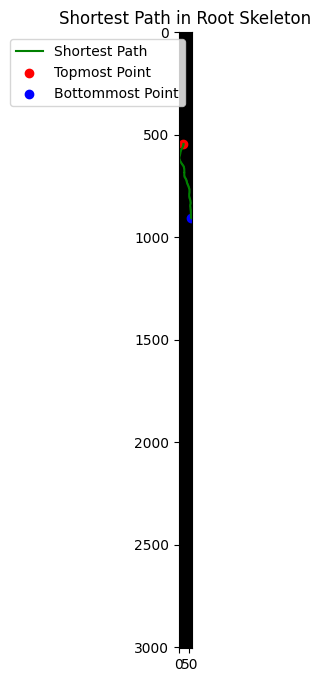

Analyzing: test_image_16_plant_4.png


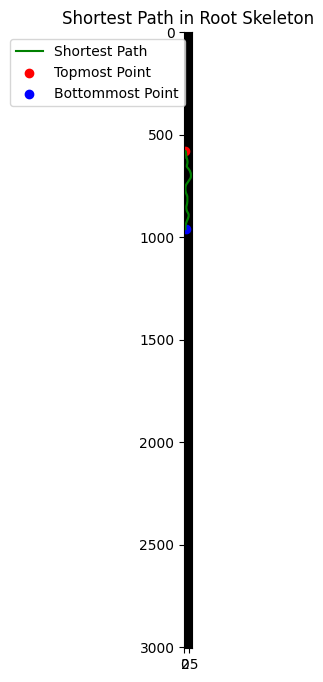

Analyzing: test_image_16_plant_5.png


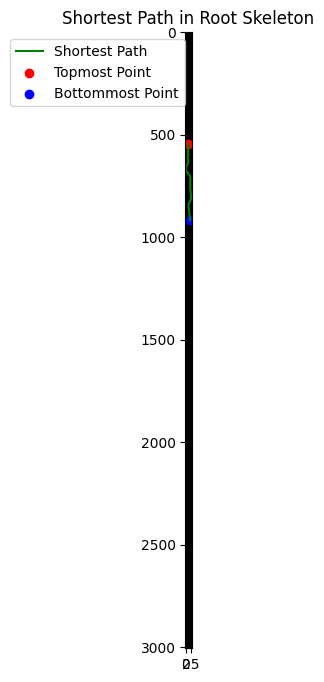

Analyzing: test_image_17_plant_1.png


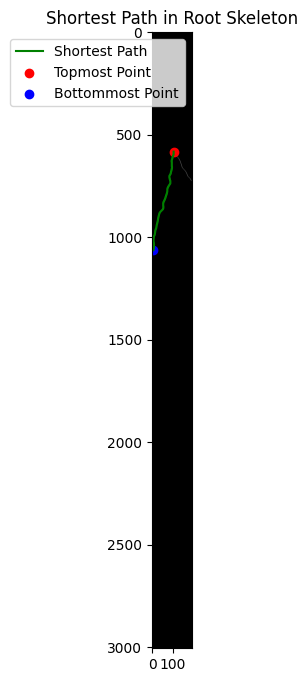

Analyzing: test_image_17_plant_2.png


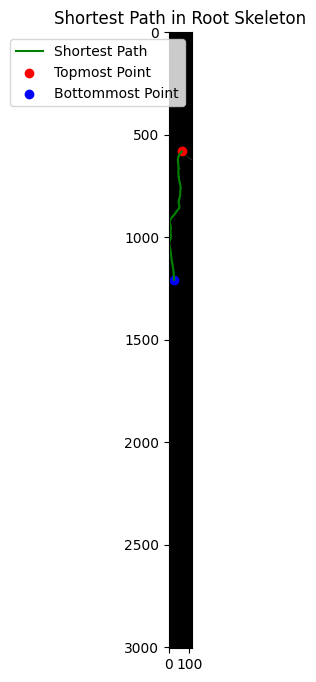

Analyzing: test_image_17_plant_3.png


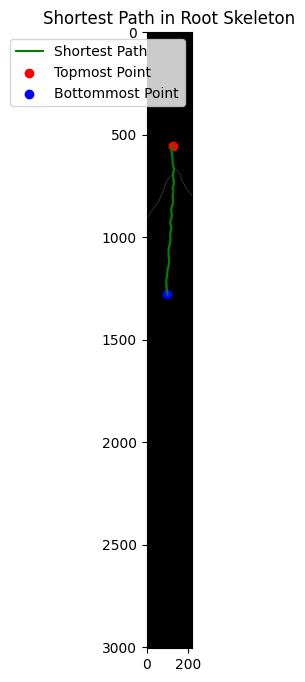

Analyzing: test_image_17_plant_4.png


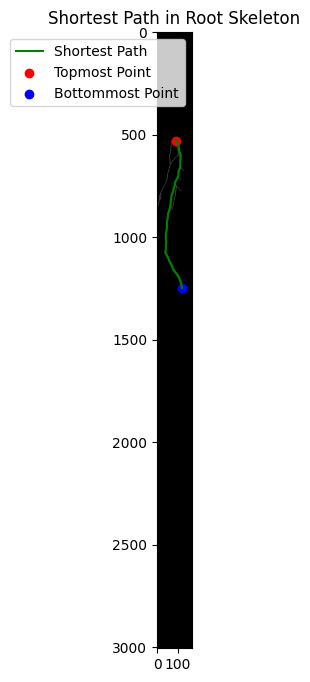

Analyzing: test_image_17_plant_5.png


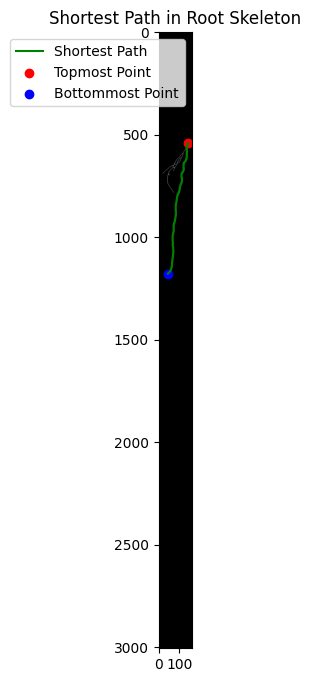

Analyzing: test_image_18_plant_1.png


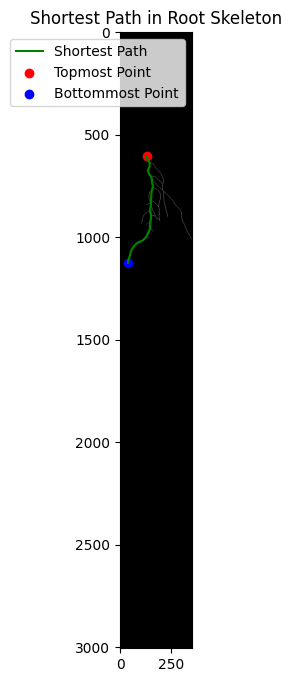

Analyzing: test_image_18_plant_2.png


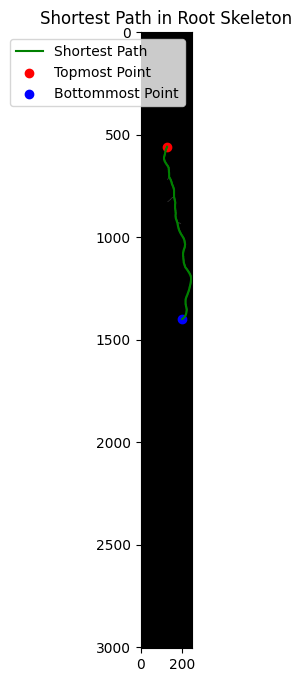

Analyzing: test_image_18_plant_4.png


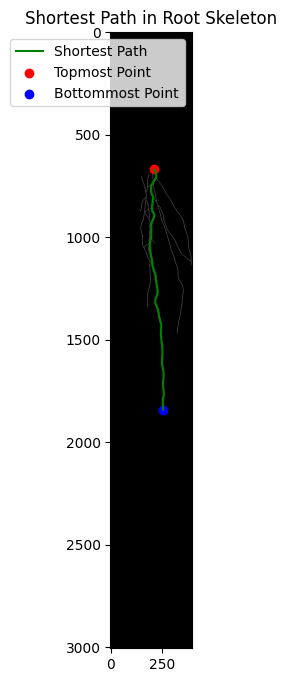

Analyzing: test_image_18_plant_5.png


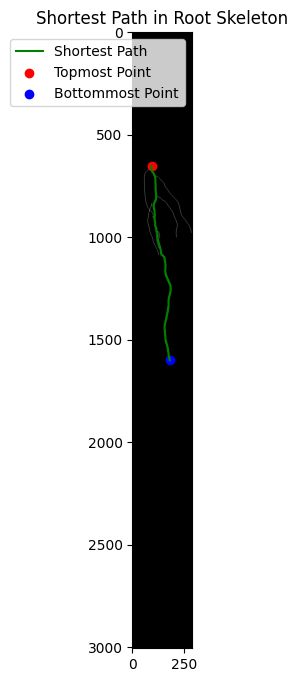

Results successfully saved to processed_root_lengths.csv


In [2]:
import os
import pandas as pd
from natsort import natsorted


# Function: Retrieve and sort image file paths
def fetch_sorted_image_paths(directory, extension=".png"):
    """
    Retrieve and naturally sort image file paths from a specified directory.
    Args:
        directory: Path to the folder containing images.
        extension: File extension to filter (default: ".png").
    Returns:
        List of naturally sorted image file paths.
    """
    return natsorted(
        [
            os.path.join(directory, file)
            for file in os.listdir(directory)
            if file.endswith(extension)
        ]
    )


# Function: Analyze a single image
def compute_image_analysis(file_path):
    """
    Analyze a single image to calculate the primary root length.
    Args:
        file_path: Path to the input image.
    Returns:
        dict: Dictionary containing the Plant ID and computed root length.
    """
    # Generate Plant ID
    file_name = os.path.basename(file_path).replace("section_", "")
    plant_id = os.path.splitext(file_name)[0].replace("root", "plant")

    # Use the skeleton extraction and path calculation functions from Code Block 1
    skeleton_data, skeleton_image = extract_skeleton_data(file_path)

    if skeleton_data is not None and skeleton_image is not None:
        # Calculate the primary root length using Code Block 1's function
        root_length = calculate_shortest_path(skeleton_image)
        root_length = round(root_length, 2) if root_length is not None else 0
    else:
        root_length = 0

    return {"Plant ID": plant_id, "Length (px)": root_length}


# Function: Batch process images and save results
def process_and_save_results(image_paths, output_csv="processed_root_lengths.csv"):
    """
    Batch process a list of images to compute root lengths and save the results to a CSV.
    Args:
        image_paths: List of image file paths to process.
        output_csv: Path to save the output CSV file.
    """
    results = []

    for path in image_paths:
        print(f"Analyzing: {os.path.basename(path)}")
        results.append(compute_image_analysis(path))

    # Save results to a DataFrame
    results_df = pd.DataFrame(results)
    results_df.to_csv(output_csv, index=False)
    print(f"Results successfully saved to {output_csv}")


# Main script execution
if __name__ == "__main__":
    # Define the directory containing processed root images
    processed_images_dir = "./processed_roots"

    # Fetch sorted paths to image files
    sorted_image_paths = fetch_sorted_image_paths(processed_images_dir)

    # Process and save results to CSV
    process_and_save_results(sorted_image_paths, output_csv="processed_root_lengths.csv")


In [3]:
import pandas as pd
import re


# Load input file and define output file
source_file = "processed_root_lengths.csv"
destination_file = "finalized_cleaned_root_lengths.csv"  

# Read the input CSV into a DataFrame
data = pd.read_csv(source_file)


# Function to extract components from Plant ID
def parse_plant_id(plant_id):
    """
    Extract base, image number, and plant number from a Plant ID.
    Args:
        plant_id: The Plant ID string to parse.
    Returns:
        tuple: (base, image_number, plant_number).
    """
    pattern = r"(.*_image_)(\d+)_plant_(\d+)"
    match = re.match(pattern, plant_id)
    if match:
        base = match.group(1)
        img_num = int(match.group(2))
        plant_num = int(match.group(3))
        return base, img_num, plant_num
    else:
        raise ValueError(f"Invalid Plant ID format: {plant_id}")


# Create a list to hold completed plant entries
completed_records = []

# Group by base and image number to ensure complete series for each image
for plant_id in data['Plant ID']:
    base, img_num, _ = parse_plant_id(plant_id)  # Parse the components

    # Ensure plants 1 through 5 are included for each base-image group
    for plant_num in range(1, 6):
        full_plant_id = f"{base}{img_num}_plant_{plant_num}"
        if full_plant_id in data['Plant ID'].values:
            # Use the existing value for the plant ID
            length_px = data[data['Plant ID'] == full_plant_id]['Length (px)'].values[0]
        else:
            # Add missing plant ID with length of 0
            length_px = 0
        completed_records.append({
            'Plant ID': full_plant_id,
            'Length (px)': length_px
        })

# Convert the completed records into a DataFrame
output_data = pd.DataFrame(completed_records)

# Remove duplicates, if any
output_data = output_data.drop_duplicates(subset=['Plant ID'])

# Sort the data by Plant ID
output_data.sort_values(by=['Plant ID'], inplace=True)

# Save the cleaned and completed data to the output CSV
output_data.to_csv(destination_file, index=False)

print(f"The cleaned and completed plant data has been saved to '{destination_file}'.")


The cleaned and completed plant data has been saved to 'finalized_cleaned_root_lengths.csv'.


In [4]:
import pandas as pd

# Function to sort the Plant ID numerically
def sort_plant_id(data):
    """
    Sorts the dataset numerically by the image number and plant number in the Plant ID.
    Args:
        data: DataFrame with a 'Plant ID' column.
    Returns:
        DataFrame sorted by image and plant numbers.
    """
    # Extract numerical parts from the Plant ID
    data['Image Number'] = data['Plant ID'].str.extract(r'_image_(\d+)_').astype(int)
    data['Plant Number'] = data['Plant ID'].str.extract(r'_plant_(\d+)$').astype(int)

    # Sort the DataFrame by Image Number and then Plant Number
    sorted_data = data.sort_values(by=['Image Number', 'Plant Number']).drop(columns=['Image Number', 'Plant Number'])
    
    return sorted_data


# Main Execution
if __name__ == "__main__":
    # Input and output file paths
    source_file = "finalized_cleaned_root_lengths.csv"
    output_file = "sorted_finalized_cleaned_root_lengths.csv"

    # Load the input CSV file
    data = pd.read_csv(source_file)

    # Apply sorting to the dataset
    sorted_data = sort_plant_id(data)

    # Save the sorted data to a new CSV file
    sorted_data.to_csv(output_file, index=False)

    print(f"Sorted data has been saved to '{output_file}'.")


Sorted data has been saved to 'sorted_finalized_cleaned_root_lengths.csv'.
